In [18]:
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import math
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# import yfinance

In [19]:
df = pd.read_csv('sales_data_spotify_standard.csv')

In [20]:
df.shape

(120, 5)

In [21]:
df.head()

,Date,Item Purchased,Unit Value,Product Name,Category
0,2023-06-01,5,15.227525,Product A,Music Streaming
1,2023-06-01,5,29.110520,Product B,Podcast Subscription
2,2023-06-01,3,48.875052,Product C,Merchandise
3,2023-06-01,4,51.046299,Product D,Concert Tickets
4,2023-06-02,4,64.679037,Product A,Music Streaming


In [22]:
df_g = df.groupby('Date')['Unit Value'].sum().reset_index().sort_values('Date')

df_g.head()

,Date,Unit Value
0,2023-06-01,144.259395
1,2023-06-02,272.570980
2,2023-06-03,184.189043
3,2023-06-04,201.097639
4,2023-06-05,258.139936


In [23]:
df_g['d_mean'] = np.mean(df_g['Unit Value'])
df_g['d_std'] = np.std(df_g['Unit Value'])

In [24]:
df_g.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        30 non-null     object 
 1   Unit Value  30 non-null     float64
 2   d_mean      30 non-null     float64
 3   d_std       30 non-null     float64
dtypes: float64(3), object(1)
memory usage: 1.1+ KB


In [25]:
df_g.head(5)

,Date,Unit Value,d_mean,d_std
0,2023-06-01,144.259395,220.282142,51.176457
1,2023-06-02,272.570980,220.282142,51.176457
2,2023-06-03,184.189043,220.282142,51.176457
3,2023-06-04,201.097639,220.282142,51.176457
4,2023-06-05,258.139936,220.282142,51.176457


Text(0, 0.5, 'Unit Value EUR')

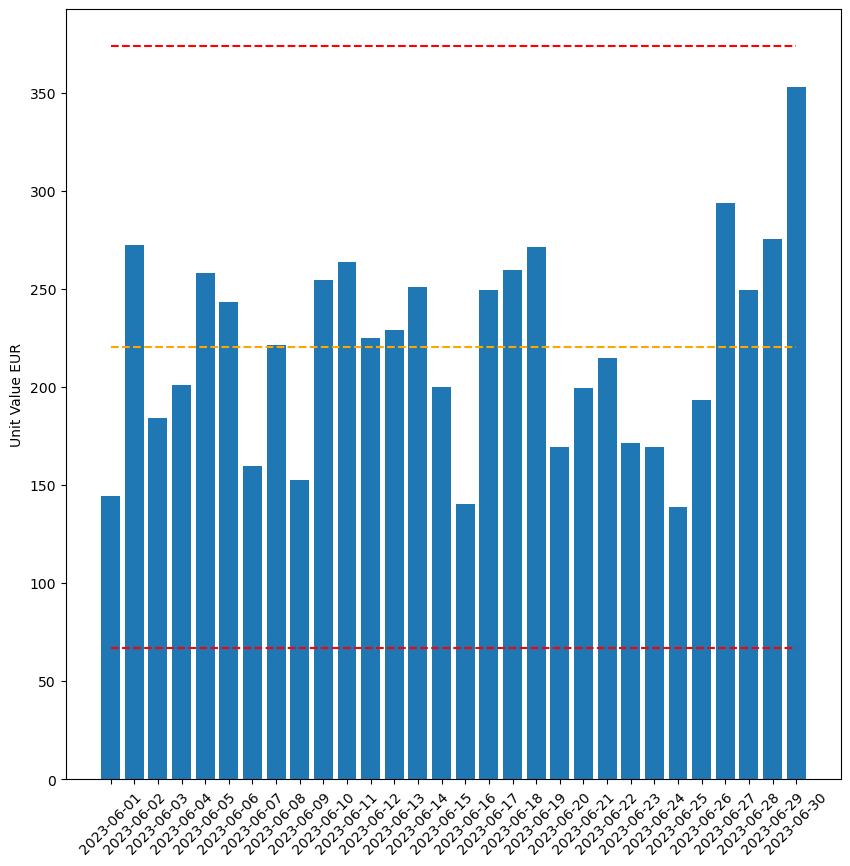

In [26]:
plt.figure(figsize=(10,10))
plt.bar(df_g.Date, df_g['Unit Value'])
plt.plot(df_g.Date, df_g.d_mean, color = 'orange', linestyle='dashed', label = 'mean')
plt.plot(df_g.Date, df_g.d_mean + (df_g.d_std*3), color = 'red', linestyle = 'dashed', label = '3 std')
plt.plot(df_g.Date, df_g.d_mean - (df_g.d_std*3), color = 'red', linestyle = 'dashed')

plt.xticks(rotation=45)
plt.ylabel('Unit Value EUR')

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

In [28]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.63321D+00    |proj g|=  2.77795D-01

At iterate    5    f=  2.52682D+00    |proj g|=  3.70683D-02

At iterate   10    f=  2.43697D+00    |proj g|=  1.06118D-02

At iterate   15    f=  2.42950D+00    |proj g|=  2.90610D-03


 This problem is unconstrained.



At iterate   20    f=  2.42853D+00    |proj g|=  1.19163D-03

At iterate   25    f=  2.42838D+00    |proj g|=  2.05856D-04

At iterate   30    f=  2.42836D+00    |proj g|=  4.19046D-04

At iterate   35    f=  2.42836D+00    |proj g|=  4.09172D-05

At iterate   40    f=  2.42836D+00    |proj g|=  8.51121D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     40     50      1     0     0   8.511D-05   2.428D+00
  F =   2.4283580266470697     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


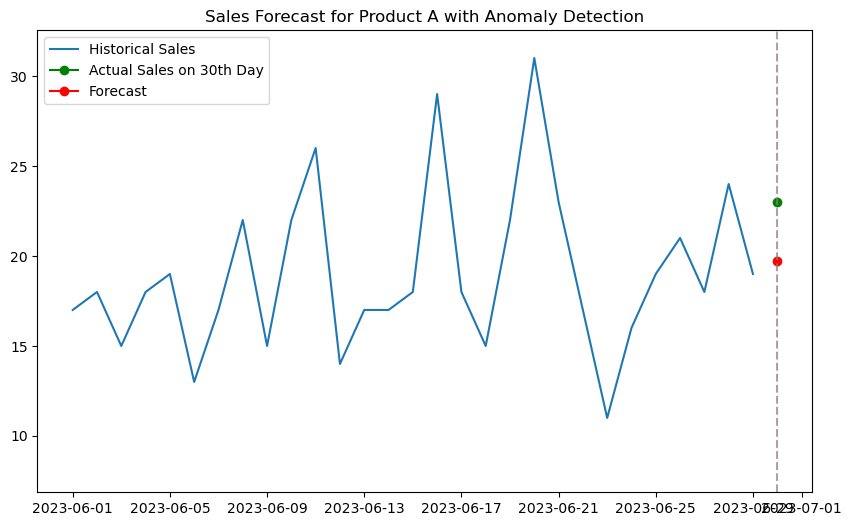

Actual sales on the 30th day: 23
Forecasted sales on the 30th day: 19.706039601987065
95% confidence interval: (8.036509471409548, 31.375569732564582)
Anomaly detected: False


In [29]:


# Filter data for a single product
product_name = 'Product A'
# df_product = df[df['Product Name'] == product_name]
df_product = df.groupby('Date').agg({'Item Purchased': 'sum'}).reset_index()

# Aggregate daily sales for the product
df_product = df_product.groupby('Date').agg({'Item Purchased': 'sum'}).reset_index()

# Convert Date to datetime format
df_product['Date'] = pd.to_datetime(df_product['Date'])
df_product.set_index('Date', inplace=True)

# Use first 29 days for training
train_data = df_product.iloc[:29]
test_data = df_product.iloc[29:30]

# Fit ARIMA model (SARIMA for seasonality consideration)
# Note: Order (p,d,q) can be optimized using auto_arima or grid search, here we use (1,1,1) as an example
model = SARIMAX(endog = train_data['Item Purchased'], order=(1, 1, 1), seasonal_order=(0, 1, 1, 7))
results = model.fit()

# Forecast the 30th day
forecast_steps = 1
forecast = results.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=train_data.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)
forecast_ci = forecast.conf_int()

# Compare actual and forecasted values to detect anomalies
actual_value = test_data['Item Purchased'].values[0]
forecasted_value = forecast_series.values[0]
lower_bound = forecast_ci.iloc[0, 0]
upper_bound = forecast_ci.iloc[0, 1]

anomaly = actual_value < lower_bound or actual_value > upper_bound

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(train_data['Item Purchased'], label='Historical Sales')
plt.plot(test_data.index, test_data['Item Purchased'], label='Actual Sales on 30th Day', color='green', marker='o')
plt.plot(forecast_series, label='Forecast', color='red', marker='o')
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title(f'Sales Forecast for {product_name} with Anomaly Detection')
plt.axvline(x=forecast_index[0], color='grey', linestyle='--', alpha=0.7)
plt.legend()

# Highlight anomaly
if anomaly:
    plt.scatter(test_data.index, test_data['Item Purchased'], color='red', s=100, zorder=5, label='Anomaly')

plt.legend()
plt.show()

# Print the results
print(f"Actual sales on the 30th day: {actual_value}")
print(f"Forecasted sales on the 30th day: {forecasted_value}")
print(f"95% confidence interval: ({lower_bound}, {upper_bound})")
print(f"Anomaly detected: {anomaly}")


In [30]:
pwd

'/Users/danielfisaha/tech_demo/clients/client1/services'